/var/folders/cy/vv8rw3d12f31t1wpxpbdgmtm0000gp/T/ipykernel_46694/3558380352.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab10', len(tickers)-1)


We have the file /Users/eartigau/bydoux_data/quotes/ZPAY.TO.fits
0.6392274777972489
['date', 'mjd', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Close_dividends', 'log_close', 'Dividend_yearly', 'day of week', 'mjd week', 'work day', 'year', 'plot_date']
We have the file /Users/eartigau/bydoux_data/quotes/EBNK.TO.fits
0.6681134742466384
['date', 'mjd', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Close_dividends', 'log_close', 'Dividend_yearly', 'day of week', 'mjd week', 'work day', 'year', 'plot_date']
We have the file /Users/eartigau/bydoux_data/quotes/ZEA.TO.fits
0.6677062764574657
['date', 'mjd', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Close_dividends', 'log_close', 'Dividend_yearly', 'day of week', 'mjd week', 'work day', 'year', 'plot_date']
We have the file /Users/eartigau/bydoux_data/quotes/DRFC.TO.fits
0.6681227727531223
['date', 'mjd', 'Ope

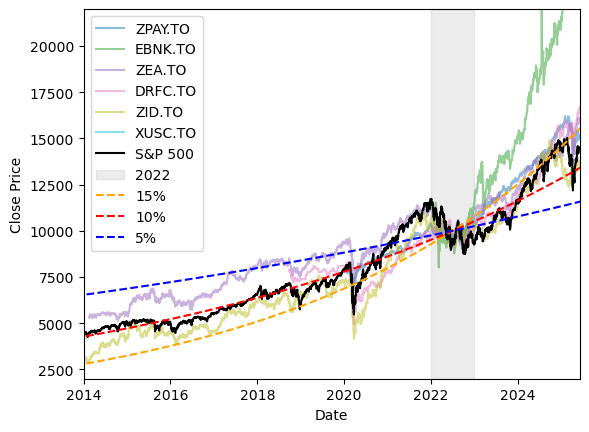

In [ ]:
import bydoux_tools as bt
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import matplotlib.cm as cm

tickers = ['ZPAY.TO','EBNK.TO','ZEA.TO','DRFC.TO','ZID.TO','XUSC.TO','^SPX']

# Define a color palette (excluding black for ^SPX)
palette = cm.get_cmap('tab10', len(tickers)-1)
colors = {ticker: palette(i) for i, ticker in enumerate(tickers) if ticker != '^SPX'}
colors['^SPX'] = 'black'

yr_societerre = [2024, 2023, 2022, 2021, 2020]  # Years for SociéTerre
rate = [16.09, 10.15, -16.12, 12.94, 18.16]  # Annual returns in percent
rate = np.array(rate) / 100  # Convert percent to fraction for plotting

ord = np.argsort(yr_societerre)
rate = rate[ord]
yr_societerre = np.array(yr_societerre)[ord]
val_societerre =  np.cumprod(1 + rate)  # Initial value of 10,000
# normalize to 2022 and multiply by 10000
val_societerre = val_societerre / np.mean(val_societerre[(yr_societerre -2022.5)<1]) * 10000

yr_societerre = [Time(f'{yr}-12-31', format='iso').datetime for yr in yr_societerre]


for ticker in tickers:
    tbl = bt.read_quotes(ticker)
    info = bt.get_info(ticker)
    if 'shortName' in info:
        short_name = info['shortName']+'/'+ticker
    else:
        short_name = ticker
    print(tbl.keys())

    tbl['time_plot'] = Time(tbl['mjd'], format='mjd').datetime

    # dates between 2022 and end of 2023
    g = (tbl['time_plot'] >= Time('2022-01-01')) & (tbl['time_plot'] <= Time('2022-12-31'))
    tbl['log_close'] -= np.mean(tbl['log_close'][g])

    if ticker == '^SPX':
        alpha = 1.0
        label = 'S&P 500'
    else:
        alpha = 0.5
        label = short_name

    plt.plot(
        tbl['time_plot'],
        np.exp(tbl['log_close'])*10000,
        label=label,
        alpha=alpha,
        color=colors[ticker]
    )



plt.axvspan(
    Time('2022-01-01').datetime,
    Time('2022-12-31').datetime,
    color='grey',
    alpha=0.15,
    label='2022'
)
# vector from 2010 to 2026
time_vector = np.linspace(Time('2010-01-01').mjd, Time('2026-01-01').mjd, 100)
dt = (time_vector - Time('2022-06-30').mjd)/365.24

plt.plot(yr_societerre, val_societerre, label='SociéTerre 100% actions', color='blue', marker='o')

plt.plot(Time(time_vector, format='mjd').datetime,  np.exp(0.15*dt) * 10000, label='15%', color='orange', linestyle='--')
plt.plot(Time(time_vector, format='mjd').datetime,  np.exp(0.10*dt) * 10000, label='10%', color='red', linestyle='--')

plt.xlim(Time('2014-01-01').datetime, Time.now().datetime)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.ylim(2000,22000)
plt.show()